# Review Sentiment Analysis

## Data Source
https://huggingface.co/datasets/lewtun/drug-reviews

## Importing libraries

In [2]:
import os
import zipfile
import pickle
import pandas as pd 
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

# To set the width of the column to maximum
pd.set_option('max_colwidth', 1)

## Importing dataset

In [3]:
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [4]:
zip_file_path = 'dataset-zip.zip'  
extraction_path = os.getcwd()  
unzip_file(zip_file_path, extraction_path)

In [5]:
df=pd.read_csv('dataset/drugsComTrain_raw.csv')

## Exploratory Data Analysis

In [6]:
df.shape

(161297, 7)

In [7]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \nWe have tried many different medications and so far this is the most effective.""",8,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",5,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",8,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I&#039;m actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin.""",9,"November 27, 2016",37


In [8]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                             9069 
Pain                                                                   6145 
Anxiety                                                                5904 
Acne                                                                   5588 
Bipolar Disorde                                                        4224 
Insomnia                                                               3673 
Weight Loss                                                            3609 
Obesity                                                                3568 
ADHD                                                                   3383 
Diabetes, Type 2                                                       2554 
Emergency Contraception                                                2463 
High Blood Pressure                                               

In [9]:
# column_to_count = df['review']  # Replace 'column_name' with the actual column name

# # Step 3: Calculate the total number of words
# total_words = column_to_count.str.split().apply(len).sum()

# print(f"Total number of words in the {column_to_count} column: {total_words}")

In [10]:
# exploring unique elements in the dataset
print("Number of Unique Drugs present in the Dataset : ", df['drugName'].nunique())
print("Number of Unique Medical Conditions present in the Dataset : ", df['condition'].nunique())

Number of Unique Drugs present in the Dataset :  3436
Number of Unique Medical Conditions present in the Dataset :  884


In [11]:
# checking for missing values
df.isna().sum()

uniqueID       0  
drugName       0  
condition      899
review         0  
rating         0  
date           0  
usefulCount    0  
dtype: int64

In [12]:
# dropping the missing values of the conditions
df = df.dropna()
df.isna().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [13]:
df['drugName'].value_counts()

drugName
Levonorgestrel                                                                                      3631
Etonogestrel                                                                                        3321
Ethinyl estradiol / norethindrone                                                                   2750
Nexplanon                                                                                           2156
Ethinyl estradiol / norgestimate                                                                    2033
Ethinyl estradiol / levonorgestrel                                                                  1809
Phentermine                                                                                         1538
Sertraline                                                                                          1353
Escitalopram                                                                                        1287
Mirena                                        

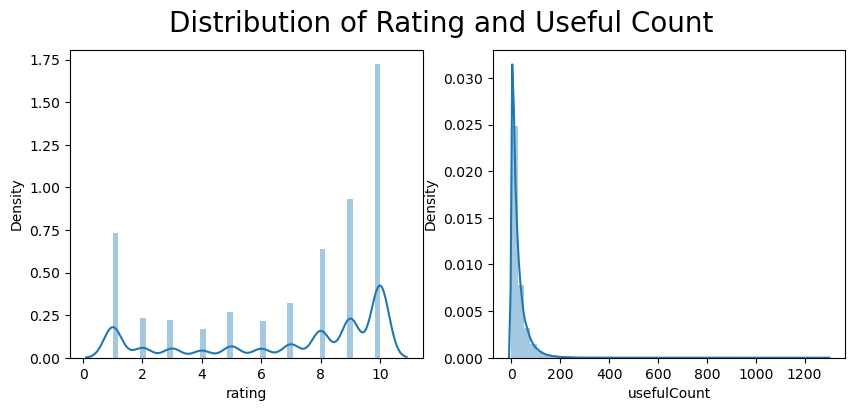

In [14]:
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(df['rating'])

plt.subplot(1, 2, 2)
sns.distplot(df['usefulCount'])

plt.suptitle('Distribution of Rating and Useful Count \n ', fontsize = 20)
plt.show()

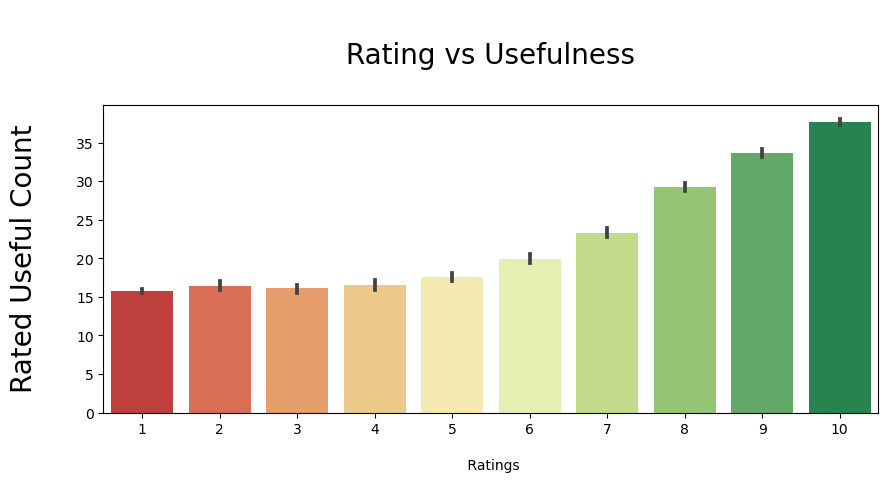

In [15]:
import seaborn as sns

# Define the custom linear gradient color palette
custom_palette = sns.color_palette("RdYlGn", 10)

plt.rcParams['figure.figsize'] = (10, 4)
sns.barplot(x=df['rating'], y=df['usefulCount'], palette=custom_palette)
plt.xlabel('\n Ratings')
plt.ylabel('Rated Useful Count\n', fontsize=20)
plt.title('\n Rating vs Usefulness \n', fontsize=20)
plt.show()


In [16]:
# Aggregate the data to count the number of occurrences for each drug-condition pair
drug_condition_count = df.groupby(['condition', 'drugName']).size().reset_index(name='count')

# Sort the data based on the count to see the most common combinations
sorted_drug_condition_count = drug_condition_count.sort_values(by='count', ascending=False)

# Display the top 20 drug-condition pairs for a sense of the most common combinations
sorted_drug_condition_count.head(20)

,condition,drugName,count
1890,Birth Control,Etonogestrel,3314
1887,Birth Control,Ethinyl estradiol / norethindrone,2337
1954,Birth Control,Nexplanon,2149
1919,Birth Control,Levonorgestrel,2129
1885,Birth Control,Ethinyl estradiol / levonorgestrel,1600
1888,Birth Control,Ethinyl estradiol / norgestimate,1580
3494,Emergency Contraception,Levonorgestrel,1221
8339,Weight Loss,Phentermine,1211
1901,Birth Control,Implanon,1095
8229,Vaginal Yeast Infection,Miconazole,997


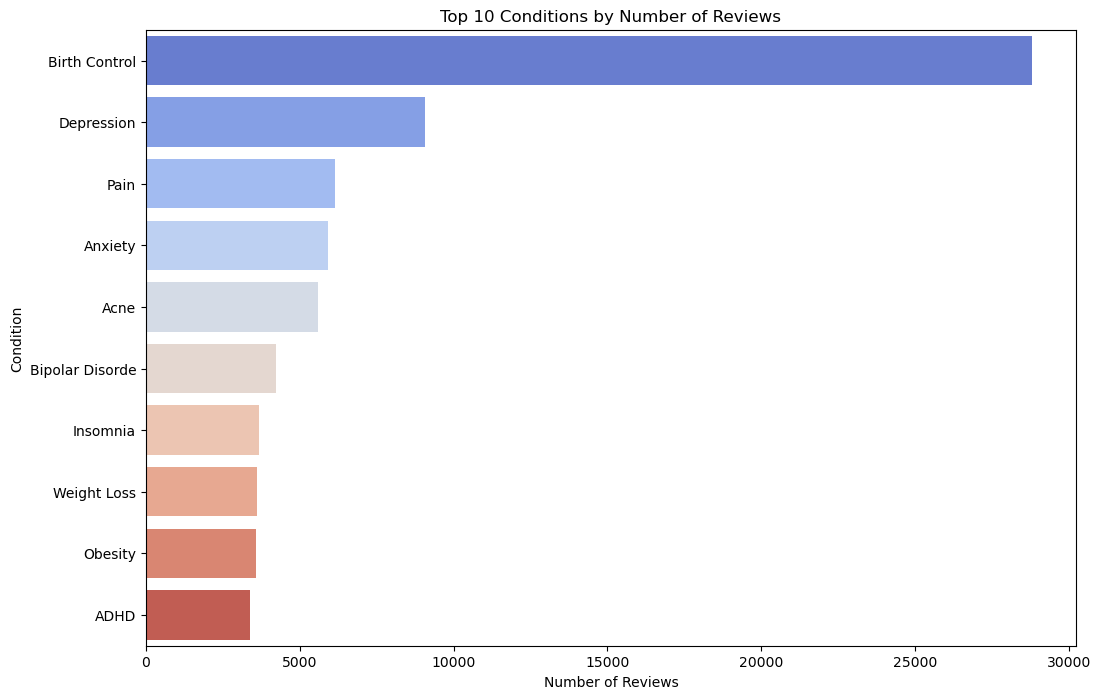

In [17]:
# To make a meaningful graph, let's first aggregate the counts of reviews per condition
condition_count = df['condition'].value_counts().reset_index()
condition_count.columns = ['condition', 'count']

# Select the top 10 conditions to keep the graph interpretable
top_conditions = condition_count.head(10)

# Plotting the top conditions by their count of reviews
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='condition', data=top_conditions, palette='coolwarm')
plt.title('Top 10 Conditions by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Condition')
plt.show()

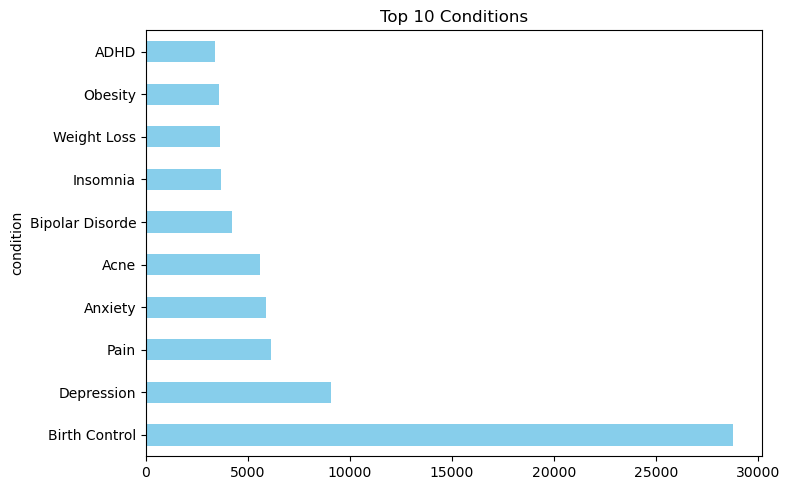

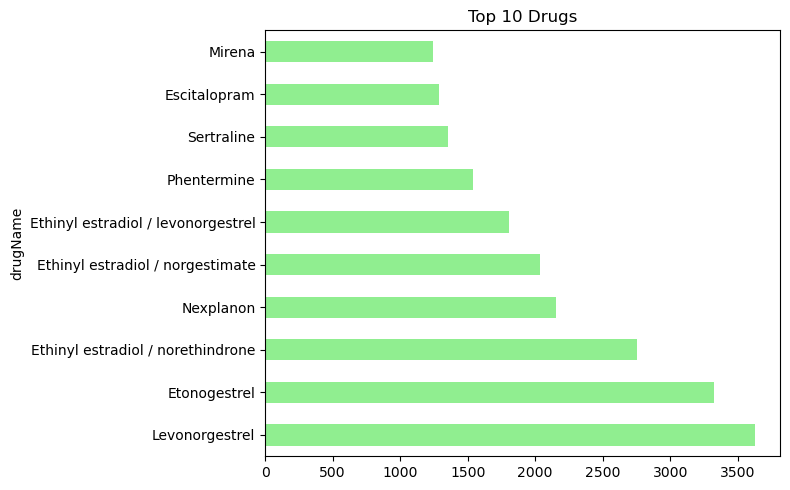

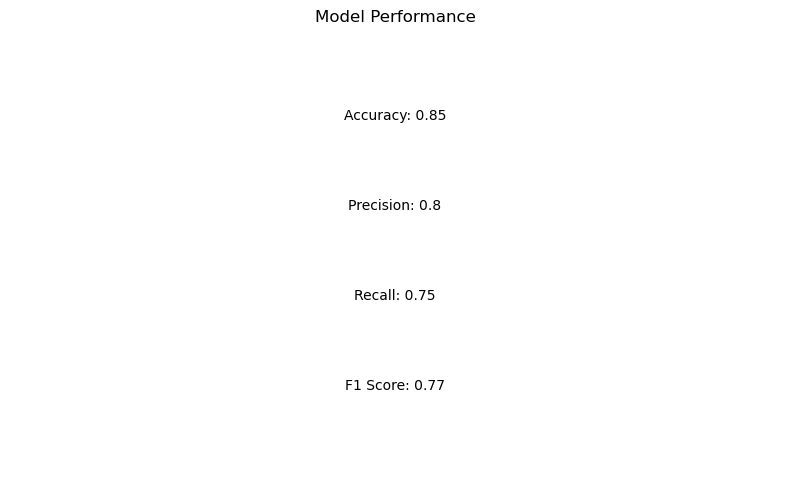

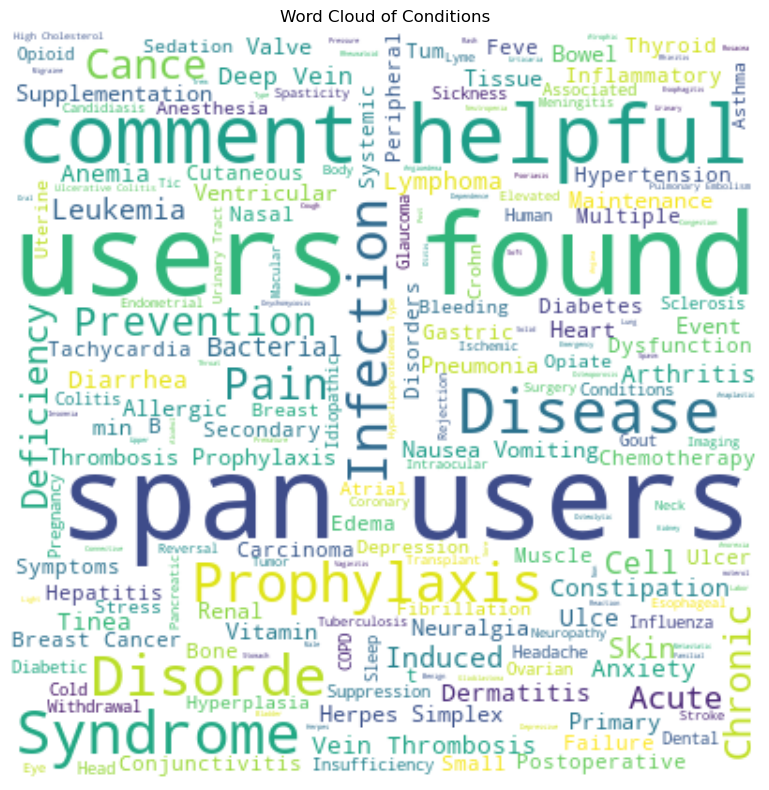

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Data for bar chart (top conditions and drugs)
top_conditions_data = df['condition'].value_counts().head(10)
top_drugs_data = df['drugName'].value_counts().head(10)

# Mock-up data for model performance (assuming generic values)
accuracy = 0.85
precision = 0.8
recall = 0.75
f1_score = 0.77

# WordCloud for conditions
wordcloud_conditions = WordCloud(background_color='white', width=400, height=400).generate(' '.join(df['condition'].dropna().unique()))

# Bar chart for conditions
plt.figure(figsize=(8, 5))
top_conditions_data.plot(kind='barh', color='skyblue')
plt.title('Top 10 Conditions')
plt.tight_layout()
plt.show()

# Bar chart for drugs
plt.figure(figsize=(8, 5))
top_drugs_data.plot(kind='barh', color='lightgreen')
plt.title('Top 10 Drugs')
plt.tight_layout()
plt.show()

# Model performance summary
plt.figure(figsize=(8, 5))
plt.text(0.5, 0.8, f'Accuracy: {accuracy}', ha='center')
plt.text(0.5, 0.6, f'Precision: {precision}', ha='center')
plt.text(0.5, 0.4, f'Recall: {recall}', ha='center')
plt.text(0.5, 0.2, f'F1 Score: {f1_score}', ha='center')
plt.axis('off')
plt.title('Model Performance')
plt.tight_layout()
plt.show()

# WordCloud for conditions
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_conditions, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Conditions')
plt.tight_layout()
plt.show()


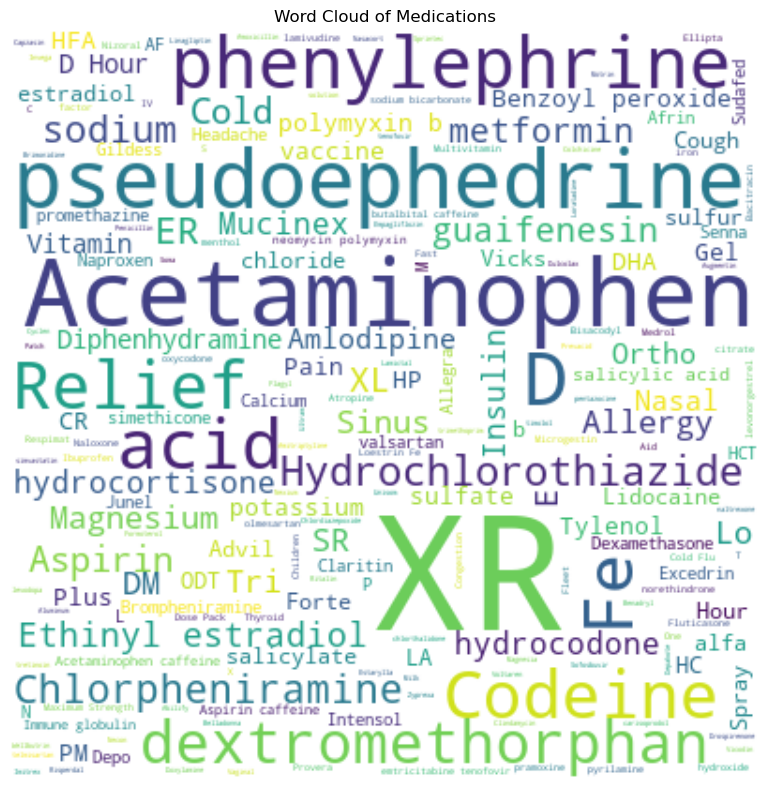

In [19]:
wordcloud_medications = WordCloud(background_color='white', width=400, height=400).generate(' '.join(df['drugName'].dropna().unique()))
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_medications, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Medications')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [20]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2') | (df['condition']=='Insomnia') | (df['condition']=='GERD') | (df['condition']=='Cough') | (df['condition']=='Acne') | (df['condition']=='Anxiety') | (df['condition']=='Constipation') | (df['condition']=='Migraine')]

In [21]:
df_train.shape

(62835, 7)

In [22]:
X = df_train.drop(['uniqueID','drugName','rating','date','usefulCount'],axis=1)

In [23]:
X.shape

(62835, 2)

In [24]:
X.condition.value_counts()

condition
Birth Control          28788
Depression             9069 
Anxiety                5904 
Acne                   5588 
Insomnia               3673 
Diabetes, Type 2       2554 
High Blood Pressure    2321 
Migraine               1694 
Constipation           1595 
Cough                  927  
GERD                   722  
Name: count, dtype: int64

In [25]:
X.isna().sum()

condition    0
review       0
dtype: int64

In [26]:
X.head()

,condition,review
2,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."""
3,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"""
9,Birth Control,"""I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger."""
11,Depression,"""I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\n\nI only take Cymbalta now mostly for pain.\n\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."""
13,Cough,"""Have a little bit of a lingering cough from a cold. Not giving me much trouble except keeps me up at night. I heard this was good so I took so I could get some sleep. Helped tremendously with the cough but then I was having bad stomach cramps and diarrhea. I hadn&#039;t eaten anything that should have upset my stomach and it didn&#039;t really feel like a &quot;bug&quot; so I looked up side effects for Delsym. Now I wish I had done that first because I probably wouldn&#039;t have taken it. So, while it worked for my cough I still didn&#039;t get any sleep due to the stomach issues."""


In [27]:
X['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [28]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\n\nI only take Cymbalta now mostly for pain.\n\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [29]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [30]:
X['review'][11]

'I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\n\nI only take Cymbalta now mostly for pain.\n\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.'

In [31]:
X.head()

,condition,review
2,Birth Control,"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."
3,Birth Control,"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"
9,Birth Control,"I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger."
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\n\nI only take Cymbalta now mostly for pain.\n\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."
13,Cough,"Have a little bit of a lingering cough from a cold. Not giving me much trouble except keeps me up at night. I heard this was good so I took so I could get some sleep. Helped tremendously with the cough but then I was having bad stomach cramps and diarrhea. I hadn&#039;t eaten anything that should have upset my stomach and it didn&#039;t really feel like a &quot;bug&quot; so I looked up side effects for Delsym. Now I wish I had done that first because I probably wouldn&#039;t have taken it. So, while it worked for my cough I still didn&#039;t get any sleep due to the stomach issues."


## Stopwords

In [32]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\suhas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
from nltk.corpus import stopwords

stop = stopwords.words('english')


In [34]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Lemmitization

In [35]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [36]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

sportingli
veri
troubl


In [37]:
print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

sportingly
very
troubled


## Review Cleaning

In [38]:
from bs4 import BeautifulSoup
import re

In [39]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [40]:
X['review_clean'] = X['review'].apply(review_to_words)

In [41]:
X.head()

,condition,review,review_clean
2,Birth Control,"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.",used take another oral contraceptive pill cycle happy light period max day side effect contained hormone gestodene available u switched lybrel ingredient similar pill ended started lybrel immediately first day period instruction said period lasted two week taking second pack two week third pack thing got even worse third period lasted two week end third week still daily brown discharge positive side side effect idea period free tempting ala
3,Birth Control,"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch",first time using form birth control glad went patch month first decreased libido subsided downside made period longer day exact used period day max also made cramp intense first two day period never cramp using birth control happy patch
9,Birth Control,"I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger.",pill many year doctor changed rx chateal effective really help completely clearing acne take month though gain extra weight develop emotional health issue stopped taking bc started using natural method birth control started take bc hate acne came back age really hope symptom like depression weight gain begin affect older also naturally moody may worsen thing negative mental rut today also hope push edge believe depressed hopefully like younger
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\n\nI only take Cymbalta now mostly for pain.\n\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.",taken anti depressant year improvement mostly moderate severe side affect make go take cymbalta mostly pain began deplin noticed major improvement overnight energy better disposition sinking low low major depression taking month feel like normal person first time ever best thing side effect
13,Cough,"Have a little bit of a lingering cough from a cold. Not giving me much 

In [42]:
X['review_clean'][11]

'taken anti depressant year improvement mostly moderate severe side affect make go take cymbalta mostly pain began deplin noticed major improvement overnight energy better disposition sinking low low major depression taking month feel like normal person first time ever best thing side effect'

## Creating features and Target Variable

In [43]:
X_feat = X['review_clean']
y = X['condition']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

## Bag of Words

In [45]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

## Directory Creation

In [46]:
# Create the "models" folder if it doesn't exist
if not os.path.exists("models"):
    os.makedirs("models")
    
if not os.path.exists("vectorizers"):
    os.makedirs("vectorizers")

In [49]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']  # Compound score represents the overall sentiment

# Apply the function to reviews
df['sentiment_score'] = df['review'].apply(get_sentiment)

# Quick look at the sentiment scores
df[['review', 'sentiment_score']].head()


,review,sentiment_score
0,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",-0.2960
1,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \nWe have tried many different medications and so far this is the most effective.""",0.8603
2,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",0.7962
3,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",0.7184
4,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I&#039;m actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin.""",0.9403


(array([18949., 13645., 10181.,  7720.,  7223.,  5973.,  5279.,  5310.,
         4091.,  3052.,  7888.,  4039.,  5009.,  5234.,  6675.,  6283.,
         8211.,  9327., 12585., 13724.]),
 array([-0.9984 , -0.89872, -0.79904, -0.69936, -0.59968, -0.5    ,
        -0.40032, -0.30064, -0.20096, -0.10128, -0.0016 ,  0.09808,
         0.19776,  0.29744,  0.39712,  0.4968 ,  0.59648,  0.69616,
         0.79584,  0.89552,  0.9952 ]),
 <BarContainer object of 20 artists>)

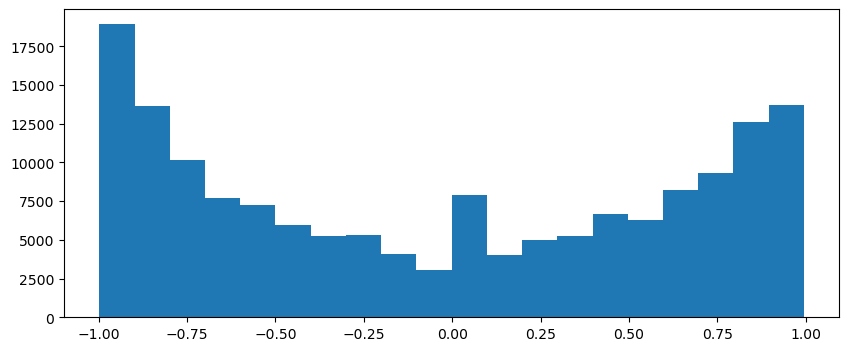

In [ ]:
plt.hist(df['sentiment_score'], bins=20)